<div style='color:white;background-color:#5b77ff; height: 100px; border-radius: 15px;'><h1 style='text-align:center;padding: 2%'>Yield Prediction in Semiconductor Manufacturing</h1></div>

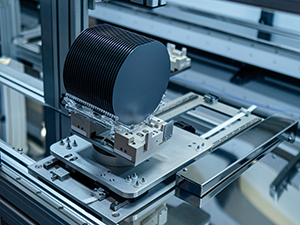
<br>
Source: Maxence Pira - Unsplash
<br>
#### Signals that acquired from sensors and process measurement sites are generally continuously monitored in a complicated semiconductor production process. In a monitoring system, not all of these signals are equally important. 

#### The measured signals comprise a mixture of insightful data, useless data, and noise. Engineers frequently have many signals than the necessary. If each form of signal is considered as a feature, <br> "Feature Selection" may be used to find the most relevant signals. 

#### These signals can then be used by Process Engineers to identify critical elements that contribute to yield excursions downstream in the process. This will allow for higher process throughput, shorter learning times, and lower takt time production costs. It can be used to forecast the yield type using characteristics. Essential signals that influence the yield type can be determined by evaluating and experimenting with different combinations of attributes.

## Table of Contents
* [Dataset Information](#data_information)
    - Data description
    - Files
    - Steps
* [Preliminary Data Exploration](#preliminary_eda)
    - Install and Import Libraries
    - Load Data
    - General Dataset Information
* [Exploratory Data Analysis](#eda)
* [Data Cleaning](#data_cleaning)
    - Drop Unused Column
    - Split Data
    - Standard Scaling
* [Modeling](#modeling)

<a id='data_information'></a>
# Dataset Information
## Data Description
<div>The dataset contains containing 1567 examples each with 591 features.The dataset presented in this case represents a selection of such features where each example represents a single production entity with associated measured features and the labels represent a simple pass/fail yield for in house line testing. Target column “ –1” corresponds to a pass and “1” corresponds to a fail and the data time stamp is for that specific test point.  
<br><br>
<b>Goal</b>:
Build a classifier to predict the Pass/Fail yield of a particular process entity and analyze whether all the features are required to build the model or not.

## Files
<span style="background-color:#e1e6e3;">uci-secom.csv</span> (1567, 592)</br>

## Steps
1. Import the necessary liberraries and read the provided CSV as a dataframe and
perform the below steps. 
a. Check a few observations and shape of the dataframe
b. Check for missing values. Impute the missing values if there is any
c. Univariate analysis - check frequency count of target column and
distribution of the first few features (sensors)
d. Perform bivariate analysis and check for the correlation
e. Drop irrelevant columns
2. Standardize the data 
3. Segregate the dependent column ("Pass/Fail") from the data frame. And split
the dataset into training and testing set ( 70:30 split) 
4. Apply sampling techniques to handle the imbalanced classes 
5. Modeling

<a id='preliminary_eda'></a>
# Preliminary Data Exploration
## Install and Import Libraries

In [1]:
# for basic operations
import numpy as np 

# Widen the display of python output
# This is done to avoid ellipsis appearing which restricts output view in row or column
import pandas as pd
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)
pd.set_option('display.width', 1000)

# for visualizations
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
%matplotlib inline


# for modeling 
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold, RepeatedStratifiedKFold, StratifiedKFold
from sklearn.model_selection import RepeatedKFold, train_test_split, RandomizedSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import  KNeighborsClassifier as knn
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import auc, accuracy_score, confusion_matrix
from sklearn.linear_model import Lasso
from sklearn.svm import OneClassSVM

# to avoid warnings
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)


from collections import Counter

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

import warnings
warnings.filterwarnings('ignore')
from IPython.core.display import HTML

## Load Data

In [2]:
# reading the data
data = pd.read_csv('../input/uci-semcom/uci-secom.csv')

# getting the shape of the data
# Dataset has 1,567 rows and 592 columns
print(data.shape)

(1567, 592)


## General Dataset Information

In [3]:
#Add a prefix to the column names for easeof understanding
data.columns = 'feature_' + data.columns

In [4]:
#Rename the time column and Pass_Fail column as they are not features 
data.rename(columns = {'feature_Time':'Time'}, inplace = True) 
data.rename(columns = {'feature_Pass/Fail':'Pass_Fail'}, inplace = True)

In [5]:
#All variables except Pass/Fail (Wether the process entity passed or not) is float. 
#Pass/Fail is a integer variable

#data.dtypes

In [6]:
# checking if the dataset contains any NULL values
# we do have NaN values if we see the output above

data.isnull().any().any()

True

In [7]:
# Replacing all the NaN values with 0 as the values correspond to the test results.
# since, the values are not present that means the values are not available or calculated
# Absence of a signal is assumed to be no signal in the dataset
# so better we not take median or mean and replace them with zeros

data = data.replace(np.NaN, 0)

# again, checking if there is any NULL values left
data.isnull().any().any()

False

<a id='eda'></a>
# Exploratory Data Analysis

In [8]:
unique_vals = data['Pass_Fail'].unique()  # [0, 1, 2]
targets = [data.loc[data['Pass_Fail'] == val] for val in unique_vals]

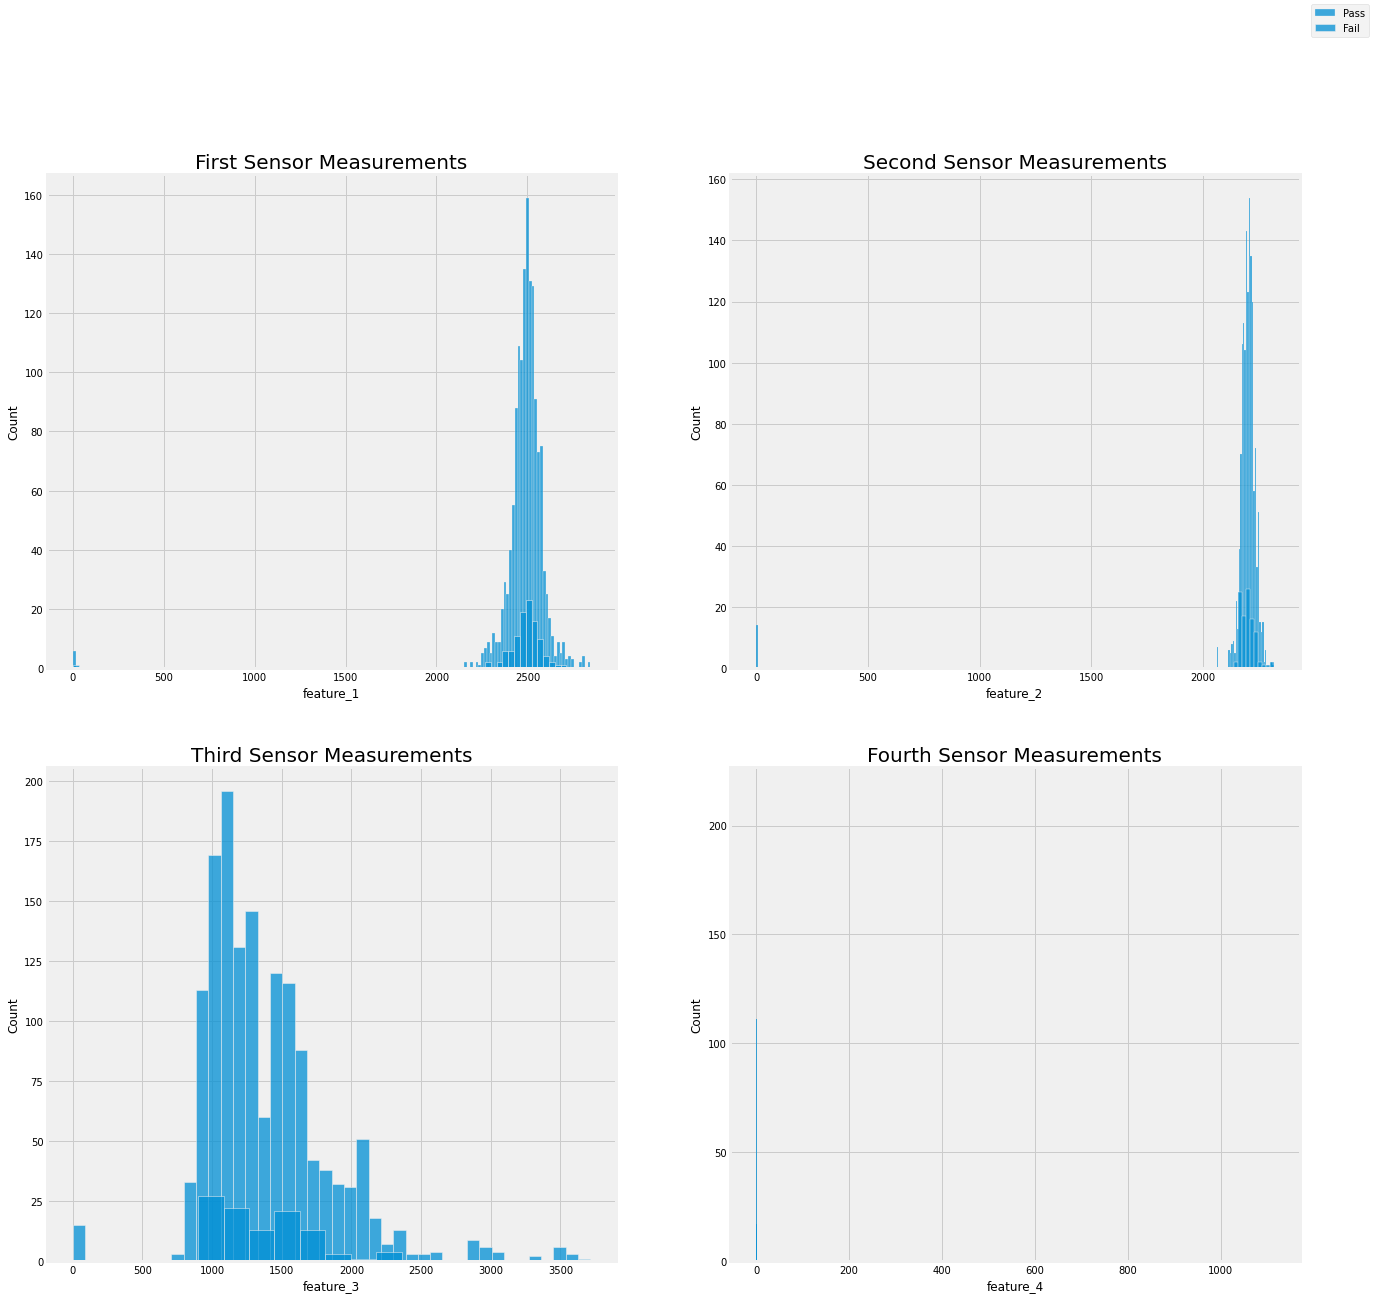

In [9]:
fig = plt.figure(figsize=(20,20))

plt.subplot(2, 2, 1)
for target in targets:
    sns.histplot(target['feature_1'])
plt.title('First Sensor Measurements', fontsize = 20)

plt.subplot(2, 2, 2)
for target in targets:
    sns.histplot(target['feature_2'])
plt.title('Second Sensor Measurements', fontsize = 20)

plt.subplot(2, 2, 3)
for target in targets:
    sns.histplot(target['feature_3'])
plt.title('Third Sensor Measurements', fontsize = 20)

plt.subplot(2, 2, 4)
for target in targets:
    sns.histplot(target['feature_4'])
plt.title('Fourth Sensor Measurements', fontsize = 20)

#sns.add_legend()
#plt.legend()
fig.legend(labels=['Pass','Fail'])
plt.show()


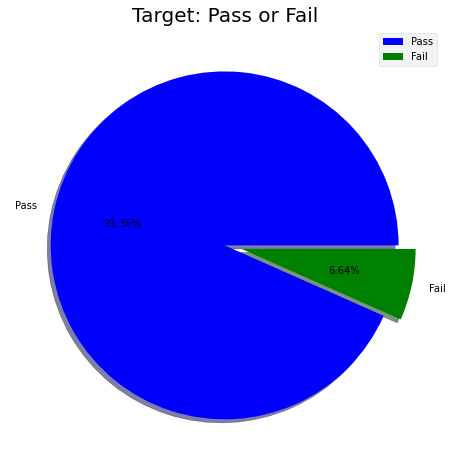

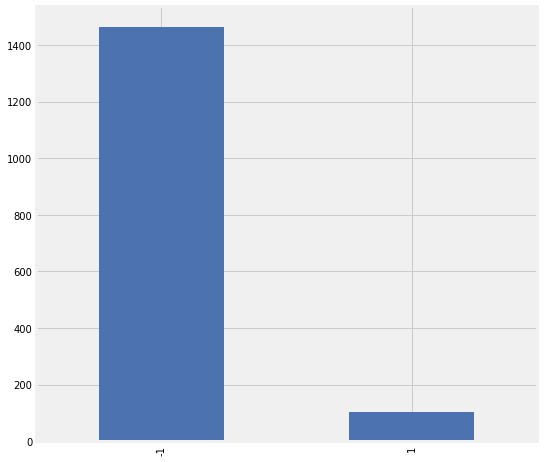

In [10]:
# pie chart
# We have highly imbalanced class with only 6.6% failures and 93.4% pass

labels = ['Pass', 'Fail']
size = data['Pass_Fail'].value_counts()
colors = ['blue', 'green']
explode = [0, 0.1]

plt.style.use('seaborn-deep')
plt.rcParams['figure.figsize'] = (8, 8)
plt.pie(size, labels =labels, colors = colors, explode = explode, autopct = "%.2f%%", shadow = True)
plt.axis('off')
plt.title('Target: Pass or Fail', fontsize = 20)
plt.legend()
plt.show()
data['Pass_Fail'].value_counts().plot(kind="bar");

In [11]:
from datetime import datetime
data['year'] = pd.DatetimeIndex(data['Time']).year
data['month'] = pd.DatetimeIndex(data['Time']).month
data['date'] = pd.DatetimeIndex(data['Time']).day
data['week_day'] = pd.DatetimeIndex(data['Time']).weekday
data['start_time'] = pd.DatetimeIndex(data['Time']).time
data['hour'] = pd.DatetimeIndex(data['Time']).hour
data['min'] = pd.DatetimeIndex(data['Time']).minute

In [12]:
#This consists of only year 2008
print("Year: ", data.year.unique())
#This consists of all the months of 2008
print("Month: ", data.month.unique())
#All the dates of the month are not there, might be related to production on certain days only
print("Date: ", data.date.unique())
#All the weekdays of the month are here, so production happens on all 7 days
#0 stand for Sunday, 1 for Monday ... 6 for Saturday
print("Weekday: ", data.week_day.unique())

Year:  [2008]
Month:  [ 7  1  2  3  4  5  6  8  9 10 11 12]
Date:  [19 20 21 22 23 25 27 28 29 30 31  8 13 15 16 17 18 24  9 14 26 10]
Weekday:  [5 6 0 1 2 4 3]


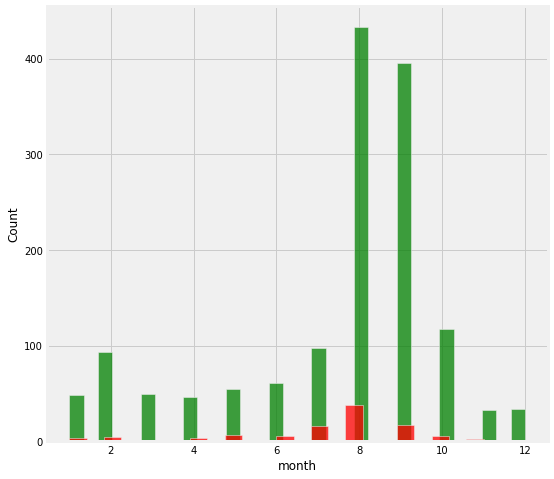

In [13]:
#We see that the failures (Pass_Fail=1) peak in August which is also the peak for pass.
#August and September are months with most product and most failures as well
#The failures seem to subside from September onwards post some correction 
#(May-Aug we see more failures than passes)
sns.histplot( data[data.Pass_Fail == -1]['month'], color = 'g');
sns.histplot( data[data.Pass_Fail == 1]['month'], color = 'r');

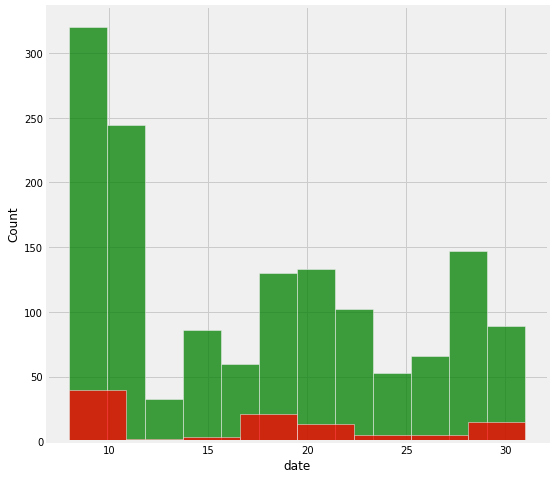

In [14]:
#The failures tend to decrease towards month end and is in close sync with pass population
sns.histplot( data[data.Pass_Fail == -1]['date'], color = 'g');
sns.histplot( data[data.Pass_Fail == 1]['date'], color = 'r');

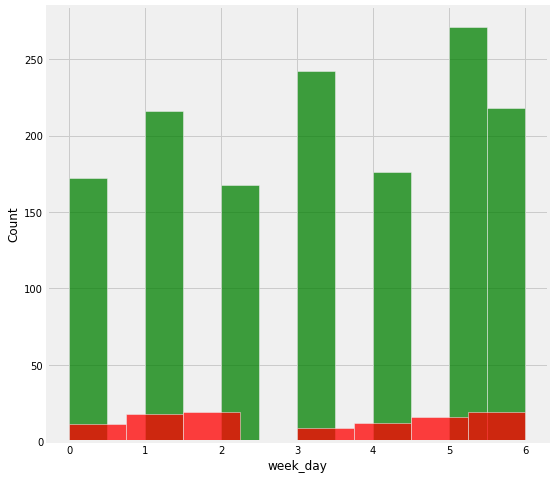

In [15]:
#Failures appear to be more towards start and end of the week rather than in the middle of the week
sns.histplot( data[data.Pass_Fail == -1]['week_day'], color = 'g');
sns.histplot( data[data.Pass_Fail == 1]['week_day'], color = 'r');

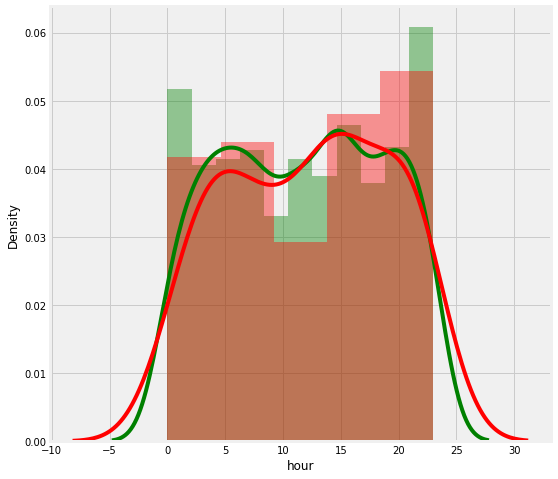

In [16]:
#There is no specific trend in terms of hours, it seems to be fairly distributed
sns.distplot( data[data.Pass_Fail == -1]['hour'], color = 'g');
sns.distplot( data[data.Pass_Fail == 1]['hour'], color = 'r');

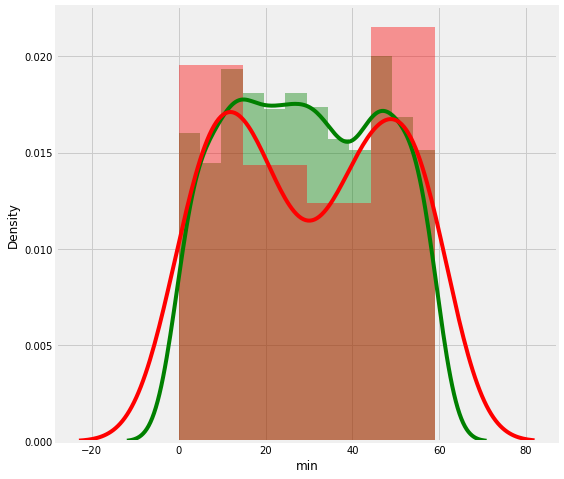

In [17]:
#There is no specific trend in terms of minutes, it seems to be fairly distributed
sns.distplot( data[data.Pass_Fail == -1]['min'], color = 'g');
sns.distplot( data[data.Pass_Fail == 1]['min'], color = 'r');

Text(0.5, 1.0, 'Correlation heatmap for the Data')

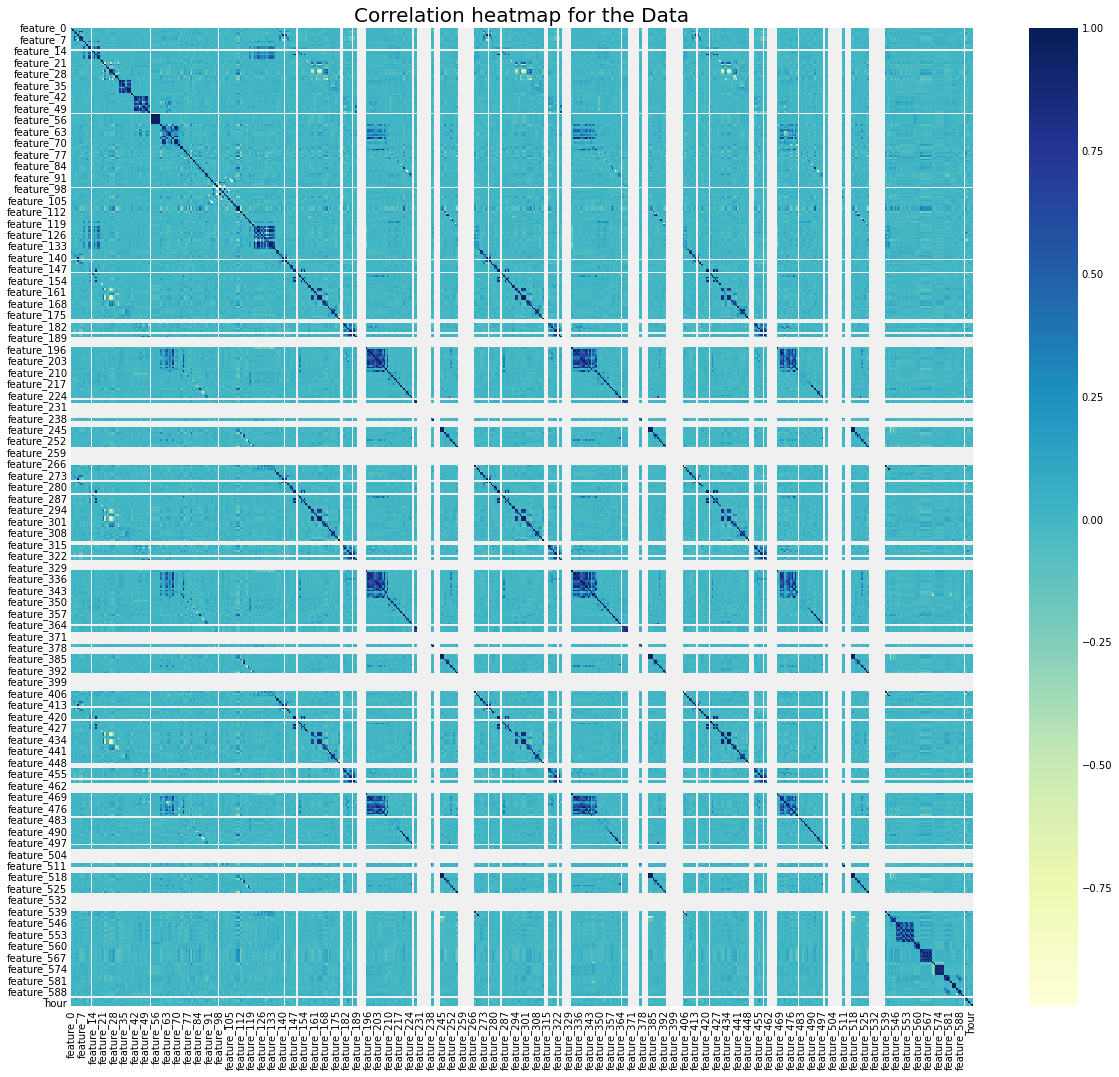

In [18]:
# heatmap to get correlation

plt.rcParams['figure.figsize'] = (18, 18)
sns.heatmap(data.corr(), cmap = "YlGnBu")
plt.title('Correlation heatmap for the Data', fontsize = 20)

<a id='data_cleaning'></a>
# Data Cleaning

In [19]:
# deleting the time column 
data = data.drop(columns = ['Time','year','month','date','week_day','start_time','hour','min'], axis = 1)

In [20]:
#Remove the highly collinear features from data
def remove_collinear_features(x, threshold):
    '''
    Objective:
        Remove collinear features in a dataframe with a correlation coefficient
        greater than the threshold. Removing collinear features can help a model 
        to generalize and improves the interpretability of the model.

    Inputs: 
        x: features dataframe
        threshold: features with correlations greater than this value are removed

    Output: 
        dataframe that contains only the non-highly-collinear features
    '''

    # Calculate the correlation matrix
    corr_matrix = x.corr()
    iters = range(len(corr_matrix.columns) - 1)
    drop_cols = []

    # Iterate through the correlation matrix and compare correlations
    for i in iters:
        for j in range(i+1):
            item = corr_matrix.iloc[j:(j+1), (i+1):(i+2)]
            col = item.columns
            row = item.index
            val = abs(item.values)

            # If correlation exceeds the threshold
            if val >= threshold:
                # Print the correlated features and the correlation value
                print(col.values[0], "|", row.values[0], "|", round(val[0][0], 2))
                drop_cols.append(col.values[0])

    # Drop one of each pair of correlated columns
    drops = set(drop_cols)
    x = x.drop(columns=drops)

    return x

In [21]:
#Remove columns having more than 70% correlation
#Both positive and negative correlations are considered here
data = remove_collinear_features(data,0.70)

feature_5 | feature_2 | 0.99
feature_6 | feature_2 | 0.82
feature_6 | feature_5 | 0.84
feature_7 | feature_2 | 0.75
feature_7 | feature_5 | 0.77
feature_12 | feature_11 | 0.83
feature_17 | feature_11 | 0.81
feature_18 | feature_11 | 0.72
feature_18 | feature_12 | 0.79
feature_18 | feature_17 | 0.9
feature_22 | feature_21 | 0.75
feature_26 | feature_25 | 0.83
feature_27 | feature_25 | 0.98
feature_27 | feature_26 | 0.79
feature_30 | feature_29 | 0.86
feature_34 | feature_32 | 0.88
feature_35 | feature_34 | 0.83
feature_37 | feature_32 | 0.75
feature_37 | feature_34 | 0.75
feature_38 | feature_32 | 0.72
feature_38 | feature_34 | 0.72
feature_38 | feature_36 | 0.71
feature_38 | feature_37 | 0.97
feature_39 | feature_32 | 0.81
feature_39 | feature_34 | 0.91
feature_39 | feature_35 | 0.71
feature_39 | feature_37 | 0.86
feature_39 | feature_38 | 0.84
feature_43 | feature_42 | 0.82
feature_44 | feature_42 | 0.82
feature_46 | feature_42 | 0.84
feature_46 | feature_43 | 0.84
feature_46 | featur

In [22]:
# separating the dependent and independent data

x = data.iloc[:,:306]
y = data["Pass_Fail"]

# getting the shapes of new data sets x and y
print("shape of x:", x.shape)
print("shape of y:", y.shape)

shape of x: (1567, 306)
shape of y: (1567,)


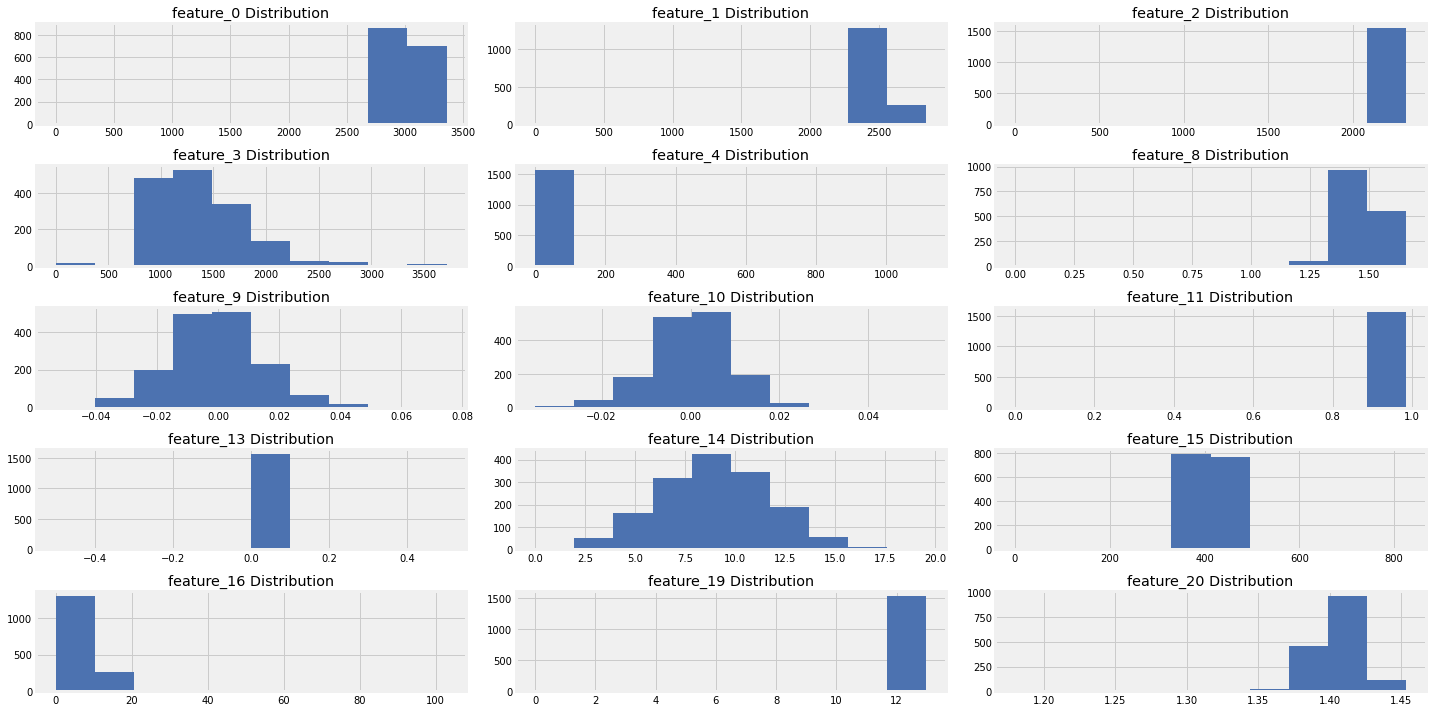

In [23]:
#Observation is that most of the variables distribution are right skewed with long tails and outliers 
def draw_histograms(df, variables, n_rows, n_cols):
    fig=plt.figure(figsize=(20,10))
    for i, var_name in enumerate(variables):
        ax=fig.add_subplot(n_rows,n_cols,i+1)
        df[var_name].hist(bins=10,ax=ax)
        ax.set_title(var_name+" Distribution")
    fig.tight_layout()  # Improves appearance a bit.
    plt.show()

#Most the variables are approximately normally distributed except for feature_4, feature_7,
#feature_11, feature_12, feature_15, feature_16
draw_histograms(data, data.iloc[:,0:15], 5, 3)

## Data Splitting

In [24]:
# separating the dependent and independent data

x = data.iloc[:,:306]
y = data["Pass_Fail"]

# getting the shapes of new data sets x and y
print("shape of x:", x.shape)
print("shape of y:", y.shape)

shape of x: (1567, 306)
shape of y: (1567,)


In [25]:
# splitting them into train test and split

from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 1)

# gettiing the shapes
print("shape of x_train: ", x_train.shape)
print("shape of x_test: ", x_test.shape)
print("shape of y_train: ", y_train.shape)
print("shape of y_test: ", y_test.shape)

shape of x_train:  (1096, 306)
shape of x_test:  (471, 306)
shape of y_train:  (1096,)
shape of y_test:  (471,)


In [26]:
# standardization

from sklearn.preprocessing import StandardScaler

# creating a standard scaler
sc = StandardScaler()

# fitting independent data to the model
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

In [27]:
from imblearn.over_sampling import SMOTE
oversample = SMOTE()
X_train, Y_train = oversample.fit_resample(x_train, y_train)

<a id='modeling'></a>
# Modeling

In [28]:
# Hyperparameter tuning takes a lot of time. If this variable is False, the tuning process will be omitted and the learning will proceed 
# with the hyperparameters already obtained. If this variable is true, you can proceed with the tuning process directly.
allow_tuning = True

In [ ]:
if allow_tuning:
    params_knn = {
        'n_neighbors' : range(1, 10),
        'weights' : ['uniform', 'distance'],
        'algorithm' : ['auto', 'ball_tree','kd_tree'],
        'p' : [1,2]
    }
    model_knn = knn()
    search_knn = GridSearchCV(model_knn, params_knn, cv=5, scoring='accuracy', n_jobs=-1, verbose=1).fit(X_train, Y_train)
    print(search_knn.best_params_)
    
    params_logistic = {
        'max_iter': [2000],
        'penalty': ['l1', 'l2'],
        'C': np.logspace(-4, 4, 20),
        'solver': ['liblinear']
    }
    model_logistic = LogisticRegression()
    search_logistic = GridSearchCV(model_logistic, params_logistic, cv=5, scoring='accuracy', n_jobs=-1, verbose=1).fit(X_train, Y_train)
    print(search_logistic.best_params_)
    
    params_svc = {'kernel': ['rbf'], 'gamma': [i/10000 for i in range(90, 110)], 'C': range(50, 80, 10), 'probability': [True]}
    model_svc = SVC()
    search_svc = GridSearchCV(model_svc, params_svc, cv=5, scoring='accuracy', n_jobs=-1, verbose=1).fit(X_train, Y_train)
    print(search_svc.best_params_)
    
    params_rf = {
        'n_estimators': [95, 100, 105],
        'criterion':['entropy'],
        'bootstrap': [True, False],
        'max_depth': [40, 45, 50],
        'max_features': [4, 5, 6],
        'min_samples_leaf': [1, 2, 3],
        'min_samples_split': [9, 10, 11],
        'random_state': [734]}
    model_rf = RandomForestClassifier()
    search_rf = GridSearchCV(model_rf, params_rf, cv=5, scoring='accuracy', n_jobs=-1, verbose=1).fit(X_train, Y_train)
    search_rf.best_params_['random_state']=242
    search_rf.best_estimator_.random_state=242
    print(search_rf.best_params_)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   27.8s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   55.2s
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed:  1.1min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


{'algorithm': 'auto', 'n_neighbors': 2, 'p': 1, 'weights': 'uniform'}
Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Done 172 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  1.3min finished


{'C': 545.5594781168514, 'max_iter': 2000, 'penalty': 'l2', 'solver': 'liblinear'}
Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   56.8s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  4.2min


In [ ]:
if allow_tuning:
    model_knn = search_knn.best_estimator_
    model_logistic = search_logistic.best_estimator_
    model_svc = search_svc.best_estimator_
    model_rf = search_rf.best_estimator_
    model_xgb = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                              colsample_bynode=1, colsample_bytree=0.8,
                              enable_categorical=False, eval_metric='logloss', gamma=0.8,gpu_id=-1, importance_type=None, interaction_constraints='',
                              learning_rate=0.15, max_delta_step=0, max_depth=5,
                              min_child_weight=1, missing=np.nan, monotone_constraints='()',
                              n_estimators=15, n_jobs=-1, num_parallel_tree=1, predictor='auto',
                              random_state=0, reg_alpha=1e-05, reg_lambda=1, scale_pos_weight=1,
                              subsample=0.8, tree_method='exact', use_label_encoder=False,
                              validate_parameters=1, verbosity=0)
else:
    model_knn = knn(algorithm='auto', 
                    n_neighbors=9,
                    p=1, 
                    weights='uniform')
    
    model_logistic = LogisticRegression(C=0.08858667904100823,
                                        max_iter=2000, 
                                        penalty='l2', 
                                        solver='liblinear')
    model_svc = SVC(C=70,
                    gamma=0.0106,
                    kernel='rbf',
                    probability=True)
    
    model_rf = RandomForestClassifier(bootstrap=True,
                                      criterion='entropy',
                                      max_depth=50, max_features=6, 
                                      min_samples_leaf=1, 
                                      min_samples_split=10, 
                                      n_estimators=100,
                                      random_state=734)
    
    model_xgb = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                              colsample_bynode=1, colsample_bytree=0.8,
                              enable_categorical=False, eval_metric='logloss', gamma=0.8,gpu_id=-1, importance_type=None, interaction_constraints='',
                              learning_rate=0.15, max_delta_step=0, max_depth=5,
                              min_child_weight=1, missing=np.nan, monotone_constraints='()',
                              n_estimators=15, n_jobs=-1, num_parallel_tree=1, predictor='auto',
                              random_state=0, reg_alpha=1e-05, reg_lambda=1, scale_pos_weight=1,
                              subsample=0.8, tree_method='exact', use_label_encoder=False,
                              validate_parameters=1, verbosity=0)

models = {
    'knn': model_knn,
    'logistic': model_logistic,
    'svc': model_svc,
    'rf': model_rf,
    'xgb': model_xgb
}

In [ ]:
import copy

# goal: The number of models to combine.
# estimaors: empty list.
# voting: voting method.
def select_models(start, cnt, goal, estimators, voting):
    if cnt == goal:
        estimators_copy = copy.deepcopy(estimators)
        voting_name = f'{voting}_' + '_'.join([i[0] for i in list(estimators_copy)])
        models[voting_name] = VotingClassifier(estimators=estimators_copy, voting=voting)
        return
    for i in range(start, 5):
        estimators.append(list(models.items())[i])
        select_models(i + 1, cnt + 1, goal, estimators, voting)
        estimators.pop()

In [ ]:
# create voting models
select_models(0, 0, 2, [], 'hard')
select_models(0, 0, 3, [], 'hard')
select_models(0, 0, 4, [], 'hard')
select_models(0, 0, 5, [], 'hard')

select_models(0, 0, 2, [], 'soft')
select_models(0, 0, 3, [], 'soft')
select_models(0, 0, 4, [], 'soft')
select_models(0, 0, 5, [], 'soft')

In [ ]:
# Dictionary for storing results for each model.
result_by_model = pd.DataFrame({'model name': models.keys(), 'model': models.values(), 'score': 0})

In [ ]:
# Cross-validation progresses for all models.
for name, model in models.items():
    result_by_model.loc[result_by_model['model name'] == name, 'score'] = cross_val_score(model, X_train,Y_train,cv=5).mean()

In [ ]:
# Cross validation scores of all models.
result_by_model.sort_values('score', ascending=False).reset_index(drop=True)

In [ ]:
model_name = 'soft_knn_rf_xgb'
models[model_name].fit(X_train, Y_train)
y_pred = models[model_name].predict(x_test).astype('int')